# LHCO Cathode Generation Pipeline
After the particle level models and the jet feature models have been trained, the final step is to run the whole generation pipeline. This is the purpose of this notebook.

## Imports

In [1]:
import os
import sys

sys.path.append("../")

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from os.path import join

import energyflow as ef
import h5py
import hydra
import numpy as np
import pytorch_lightning as pl
import torch
from omegaconf import OmegaConf
from sklearn.neighbors import KernelDensity

2023-09-22 13:19:32.235067: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-22 13:19:33.437273: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
# plots and metrics
import matplotlib.pyplot as plt

from src.data.components import (
    calculate_all_wasserstein_metrics,
    inverse_normalize_tensor,
    normalize_tensor,
)
from src.utils.data_generation import generate_data
from src.utils.plotting import apply_mpl_styles, plot_data, prepare_data_for_plotting

apply_mpl_styles()

In [4]:
# set env variable DATA_DIR again because of hydra
from dotenv import load_dotenv

load_dotenv()
os.environ["DATA_DIR"] = os.environ.get("DATA_DIR")

In [5]:
data_folder = os.environ.get("DATA_DIR")

# Generate mjj samples
We fit a KDE to the mjj distribution of the signal and background samples. We then sample from the KDE to generate new mjj samples in the signal region.

In [6]:
n_samples = 200_000

In [7]:
path = f"{data_folder}/lhco/final_data/processed_data_background_rel.h5"
with h5py.File(path, "r") as f:
    jets = f["jet_data"][:]

In [8]:
p4_jets = ef.p4s_from_ptyphims(jets)

In [9]:
sum_p4 = p4_jets[:, 0] + p4_jets[:, 1]
mjj = ef.ms_from_p4s(sum_p4)

In [10]:
args_to_keep = ((mjj < 3300) & (mjj > 2300)) | ((mjj > 3700) & (mjj < 5000))
args_to_keep_sr = (mjj > 3300) & (mjj < 3700)

In [11]:
mjj_sb = mjj[args_to_keep]
mjj_sr = mjj[args_to_keep_sr]
args_to_keep_sb_sr = args_to_keep | args_to_keep_sr
mjj_sb_sr = mjj[args_to_keep_sb_sr]

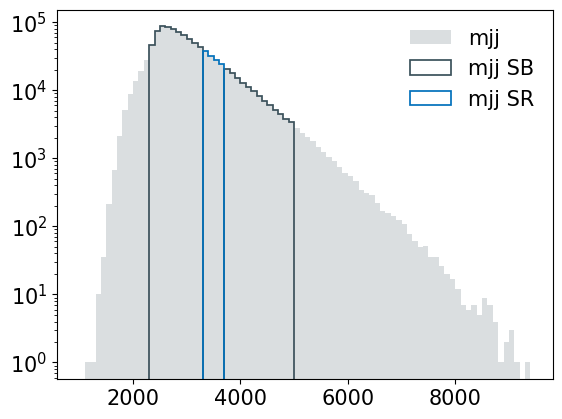

In [12]:
hist = plt.hist(
    mjj, bins=np.arange(1e3, 9.5e3, 0.1e3), histtype="stepfilled", label="mjj", alpha=0.5
)
plt.hist(mjj_sb, bins=hist[1], histtype="step", label="mjj SB")
plt.hist(mjj_sr, bins=hist[1], histtype="step", label="mjj SR")

plt.legend(frameon=False)
plt.yscale("log")
plt.show()

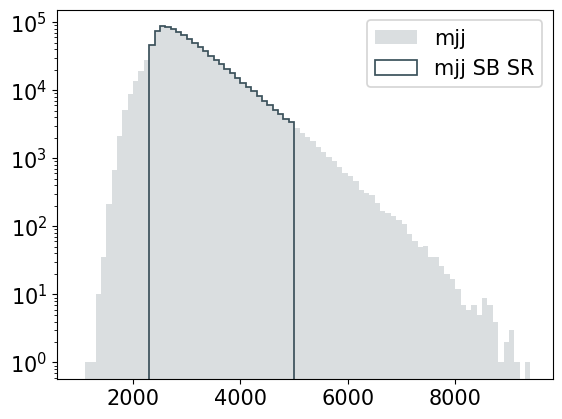

In [13]:
hist = plt.hist(
    mjj, bins=np.arange(1e3, 9.5e3, 0.1e3), histtype="stepfilled", label="mjj", alpha=0.5
)
plt.hist(mjj_sb_sr, bins=hist[1], histtype="step", label="mjj SB SR")

plt.legend()
plt.yscale("log")
plt.show()

### fit KDE on SR and SB

In [14]:
kde_model_sb_sr = KernelDensity(kernel="gaussian", bandwidth=0.001)
kde_model_sb_sr.fit(mjj_sb_sr.reshape(-1, 1))

samples_sb_sr = kde_model_sb_sr.sample(n_samples * 10)

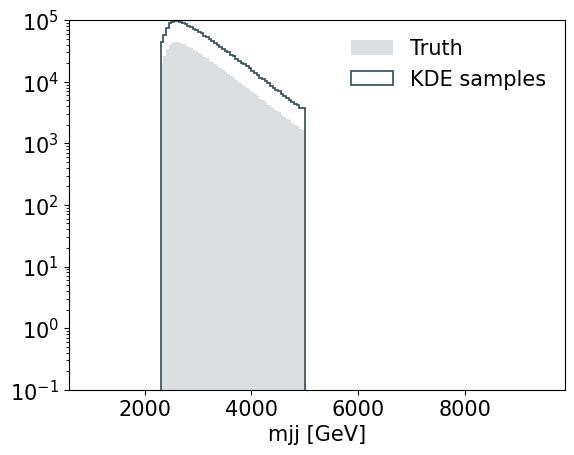

In [15]:
hist = plt.hist(
    mjj_sb_sr,
    bins=np.arange(1e3, 9.5e3, 0.05e3),
    histtype="stepfilled",
    label="Truth",
    alpha=0.5,
)
plt.hist(samples_sb_sr, bins=hist[1], histtype="step", label="KDE samples")
plt.xlabel("mjj [GeV]")
plt.ylim(1e-1, 1e5)
plt.legend(frameon=False)
plt.yscale("log")
plt.show()

### only take SR data

In [16]:
args_to_keep_sr_samples = (samples_sb_sr > 3300) & (samples_sb_sr < 3700)
mjj_samples_sr = samples_sb_sr[args_to_keep_sr_samples]

In [17]:
mjj_samples_sr = mjj_samples_sr[:n_samples]

In [7]:
path_mjj = f"{data_folder}/lhco/generated/mjj_data.h5"

In [19]:
# with h5py.File(path_mjj, "w") as f:
#    f.create_dataset("mjj", data=mjj_samples_sr)

In [12]:
with h5py.File(path_mjj, "r") as f:
    mjj_samples_sr = f["mjj"][:]

In [21]:
print(mjj_samples_sr.shape)

(200000,)


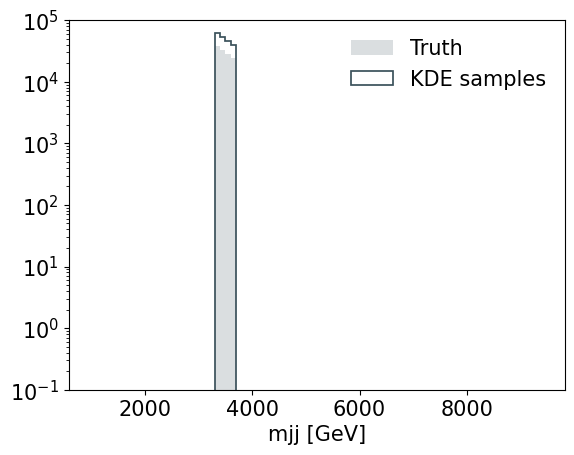

In [22]:
hist = plt.hist(
    mjj_sr,
    bins=np.arange(1e3, 9.5e3, 0.1e3),
    histtype="stepfilled",
    label="Truth",
    alpha=0.5,
)
plt.hist(mjj_samples_sr, bins=hist[1], histtype="step", label="KDE samples")
plt.ylim(1e-1, 1e5)
plt.xlabel("mjj [GeV]")
plt.legend(frameon=False)
plt.yscale("log")
plt.show()

# Generate from Jet Feature Model

### Load model

In [23]:
experiment = "/lhco/lhco_jet_features.yaml"

In [24]:
# load everything from experiment config
with hydra.initialize(version_base=None, config_path="../configs/"):
    cfg = hydra.compose(config_name="train.yaml", overrides=[f"experiment={experiment}"])
    # print(OmegaConf.to_yaml(cfg))

In [25]:
datamodule = hydra.utils.instantiate(cfg.data)
model = hydra.utils.instantiate(cfg.model)

In [26]:
datamodule.setup()

217119 events are removed due to the window cut.
Train dataset size: 469729
Validation dataset size: 39144
Test dataset size: 274008


In [27]:
test_data_sr = np.array(datamodule.tensor_test_sr)
test_cond_sr = np.array(datamodule.tensor_conditioning_test_sr)
val_data_sr = np.array(datamodule.tensor_val_sr)
val_cond_sr = np.array(datamodule.tensor_conditioning_val_sr)
train_data_sr = np.array(datamodule.tensor_train_sr)
train_cond_sr = np.array(datamodule.tensor_conditioning_train_sr)
means = np.array(datamodule.means)
stds = np.array(datamodule.stds)
means_cond = np.array(datamodule.cond_means)
stds_cond = np.array(datamodule.cond_stds)

In [28]:
print(datamodule.tensor_train.shape)
tes = inverse_normalize_tensor(datamodule.tensor_train, means, stds)
tes = datamodule.tensor_train.numpy()
print(np.min(tes[:,4]))
print(np.min(tes[:,9]))
print(np.max(tes[:,4]))
print(np.max(tes[:,9]))


torch.Size([469729, 10])
1.0
0.9999962
242.0
255.00002


### Load checkpoint

In [29]:
ckpt = (
    "/beegfs/desy/user/ewencedr/deep-learning/logs/lhco jet features with particle"
    " multiplicity/runs/2023-08-16_14-58-31/checkpoints/last-EMA.ckpt"
)

ckpt = "/beegfs/desy/user/ewencedr/deep-learning/logs/lhco jet features new/runs/2023-09-19_00-55-11/checkpoints/last-EMA.ckpt"
model = model.load_from_checkpoint(ckpt)

### Generate Data

In [30]:
# normalize conditioning variables
normalized_cond = normalize_tensor(
    torch.tensor(mjj_samples_sr, dtype=torch.float).clone().unsqueeze(-1),
    means_cond,
    stds_cond,
    datamodule.hparams.normalize_sigma,
)

In [31]:
print(normalized_cond.shape)

torch.Size([200000, 1])


In [32]:
torch.manual_seed(9999)
data_jet_feature_temp, generation_time = generate_data(
    model,
    num_jet_samples=n_samples,
    batch_size=2048,
    cond=normalized_cond[:n_samples],
    normalized_data=datamodule.hparams.normalize,
    means=datamodule.means,
    stds=datamodule.stds,
    ode_solver="midpoint",
    ode_steps=250,
)

Generating data (200000 samples). Device: cuda


100%|██████████| 97/97 [00:39<00:00,  2.47it/s]


In [33]:
# shift phi values to [-pi, pi]
data_jet_feature_temp[:, 2][data_jet_feature_temp[:, 2] > np.pi] -= 2 * np.pi
data_jet_feature_temp[:, 2][data_jet_feature_temp[:, 2] < -np.pi] += 2 * np.pi
data_jet_feature_temp[:, 7][data_jet_feature_temp[:, 7] > np.pi] -= 2 * np.pi
data_jet_feature_temp[:, 7][data_jet_feature_temp[:, 7] < -np.pi] += 2 * np.pi

In [34]:
#clip particle multiplicity
data_jet_feature_temp[:, 4][data_jet_feature_temp[:, 4] < 1] = 1
data_jet_feature_temp[:, 4][data_jet_feature_temp[:, 4] > 279] = 279
data_jet_feature_temp[:, 9][data_jet_feature_temp[:, 9] < 1] = 1
data_jet_feature_temp[:, 9][data_jet_feature_temp[:, 9] > 279] = 279

In [35]:
data_jet_feature = data_jet_feature_temp

In [36]:
mask_x_ints = data_jet_feature[:, 4]
mask_y_ints = data_jet_feature[:, 9]

In [37]:
n_classes_x = 279
targets_x = np.rint(mask_x_ints).astype(int)
mask_x = np.expand_dims(np.tril(np.ones((n_classes_x, n_classes_x)), k=-1)[targets_x], axis=-1)

In [38]:
n_classes_y = 279
targets_y = np.rint(mask_y_ints).astype(int)
mask_y = np.expand_dims(np.tril(np.ones((n_classes_y, n_classes_y)), k=-1)[targets_y], axis=-1)

In [39]:
print(np.min(data_jet_feature_temp[:, 4]))
print(np.min(data_jet_feature_temp[:, 9]))
print(np.max(data_jet_feature_temp[:, 4]))
print(np.max(data_jet_feature_temp[:, 9]))
print(np.where(data_jet_feature_temp[:, 9] < 0))

2.1184845
1.0
238.2008
254.93817
(array([], dtype=int64),)


In [40]:
data_jet_feature_temp[:, 4] = np.rint(data_jet_feature_temp[:, 4])
data_jet_feature_temp[:, 9] = np.rint(data_jet_feature_temp[:, 9])

In [41]:
print(np.min(data_jet_feature_temp[:, 4]))
print(np.min(data_jet_feature_temp[:, 9]))
print(np.max(data_jet_feature_temp[:, 4]))
print(np.max(data_jet_feature_temp[:, 9]))
print(np.where(data_jet_feature_temp[:, 9] < 0))

2.0
1.0
238.0
255.0
(array([], dtype=int64),)


In [42]:
print(np.max(np.sum(mask_x, axis=1)))
print(np.max(np.sum(mask_y, axis=1)))
print(np.min(np.sum(mask_x, axis=1)))
print(np.min(np.sum(mask_y, axis=1)))

238.0
255.0
2.0
1.0


In [43]:
path_jet_features = f"{data_folder}/lhco/generated/jet_features_pto.h5"

In [44]:
print(data_jet_feature.shape)

(200000, 10)


In [9]:
path_jet_features_full = f"{data_folder}/lhco/generated/jet_features_full.h5"
#with h5py.File(path_jet_features_full, "w") as f:
#    f.create_dataset("jet_features_x", data=data_jet_feature[..., :5])
#    f.create_dataset("jet_features_y", data=data_jet_feature[..., 5:])
#    f.create_dataset("mask_x", data=mask_x)
#    f.create_dataset("mask_y", data=mask_y)
#    f.create_dataset("mjj", data=mjj_samples_sr)

In [11]:
with h5py.File(path_jet_features_full, "r") as f:
    data_jet_feature = np.concatenate(
        [f["jet_features_x"][:], f["jet_features_y"][:]], axis=-1
    )
    mask_x = f["mask_x"][:]
    mask_y = f["mask_y"][:]
    mjj_samples_sr2 = f["mjj"][:]

In [14]:
pv = "/beegfs/desy/user/ewencedr/data/lhco/generated/FPCD_LHCO_SR.h5"
with h5py.File(path_jet_features_full, "r") as f:
    #data_jet_feature = np.concatenate(
    #    [f["jet_features_x"][:], f["jet_features_y"][:]], axis=-1
    #)
    #mask_xv = f["mask_x"][:]
    #mask_yv = f["mask_y"][:]
    mjj_samples_sr3 = f["mjj"][:]

In [15]:
print(mjj_samples_sr)
print(mjj_samples_sr2)
print(mjj_samples_sr3)

[3455.99132272 3678.11585625 3471.73113703 ... 3324.43490945 3388.83301586
 3539.77864201]
[3455.99132272 3678.11585625 3471.73113703 ... 3324.43490945 3388.83301586
 3539.77864201]
[3455.99132272 3678.11585625 3471.73113703 ... 3324.43490945 3388.83301586
 3539.77864201]


In [47]:
print(mask_x.shape)

(200000, 279, 1)


In [48]:
print(np.max(np.sum(mask_x, axis=1)))
print(np.max(np.sum(mask_y, axis=1)))
print(np.min(np.sum(mask_x, axis=1)))
print(np.min(np.sum(mask_y, axis=1)))
print(np.where(np.sum(mask_y, axis=1) == 278))

238.0
255.0
2.0
1.0
(array([], dtype=int64), array([], dtype=int64))


In [64]:
#array([ 34491, 108474])
#print(mask_y[34491])
print(data_jet_feature_temp[34491, 4])

52.0


In [66]:
#with h5py.File(path_jet_features, "w") as f:
#   f.create_dataset("jet_features", data=data_jet_feature)

In [ ]:
with h5py.File(path_jet_features, "r") as f:
    data_jet_feature = f["jet_features"][:]

In [ ]:
print(data_jet_feature.shape)

(120000, 10)


In [97]:
np.count_nonzero(np.isnan(data_jet_feature))

0

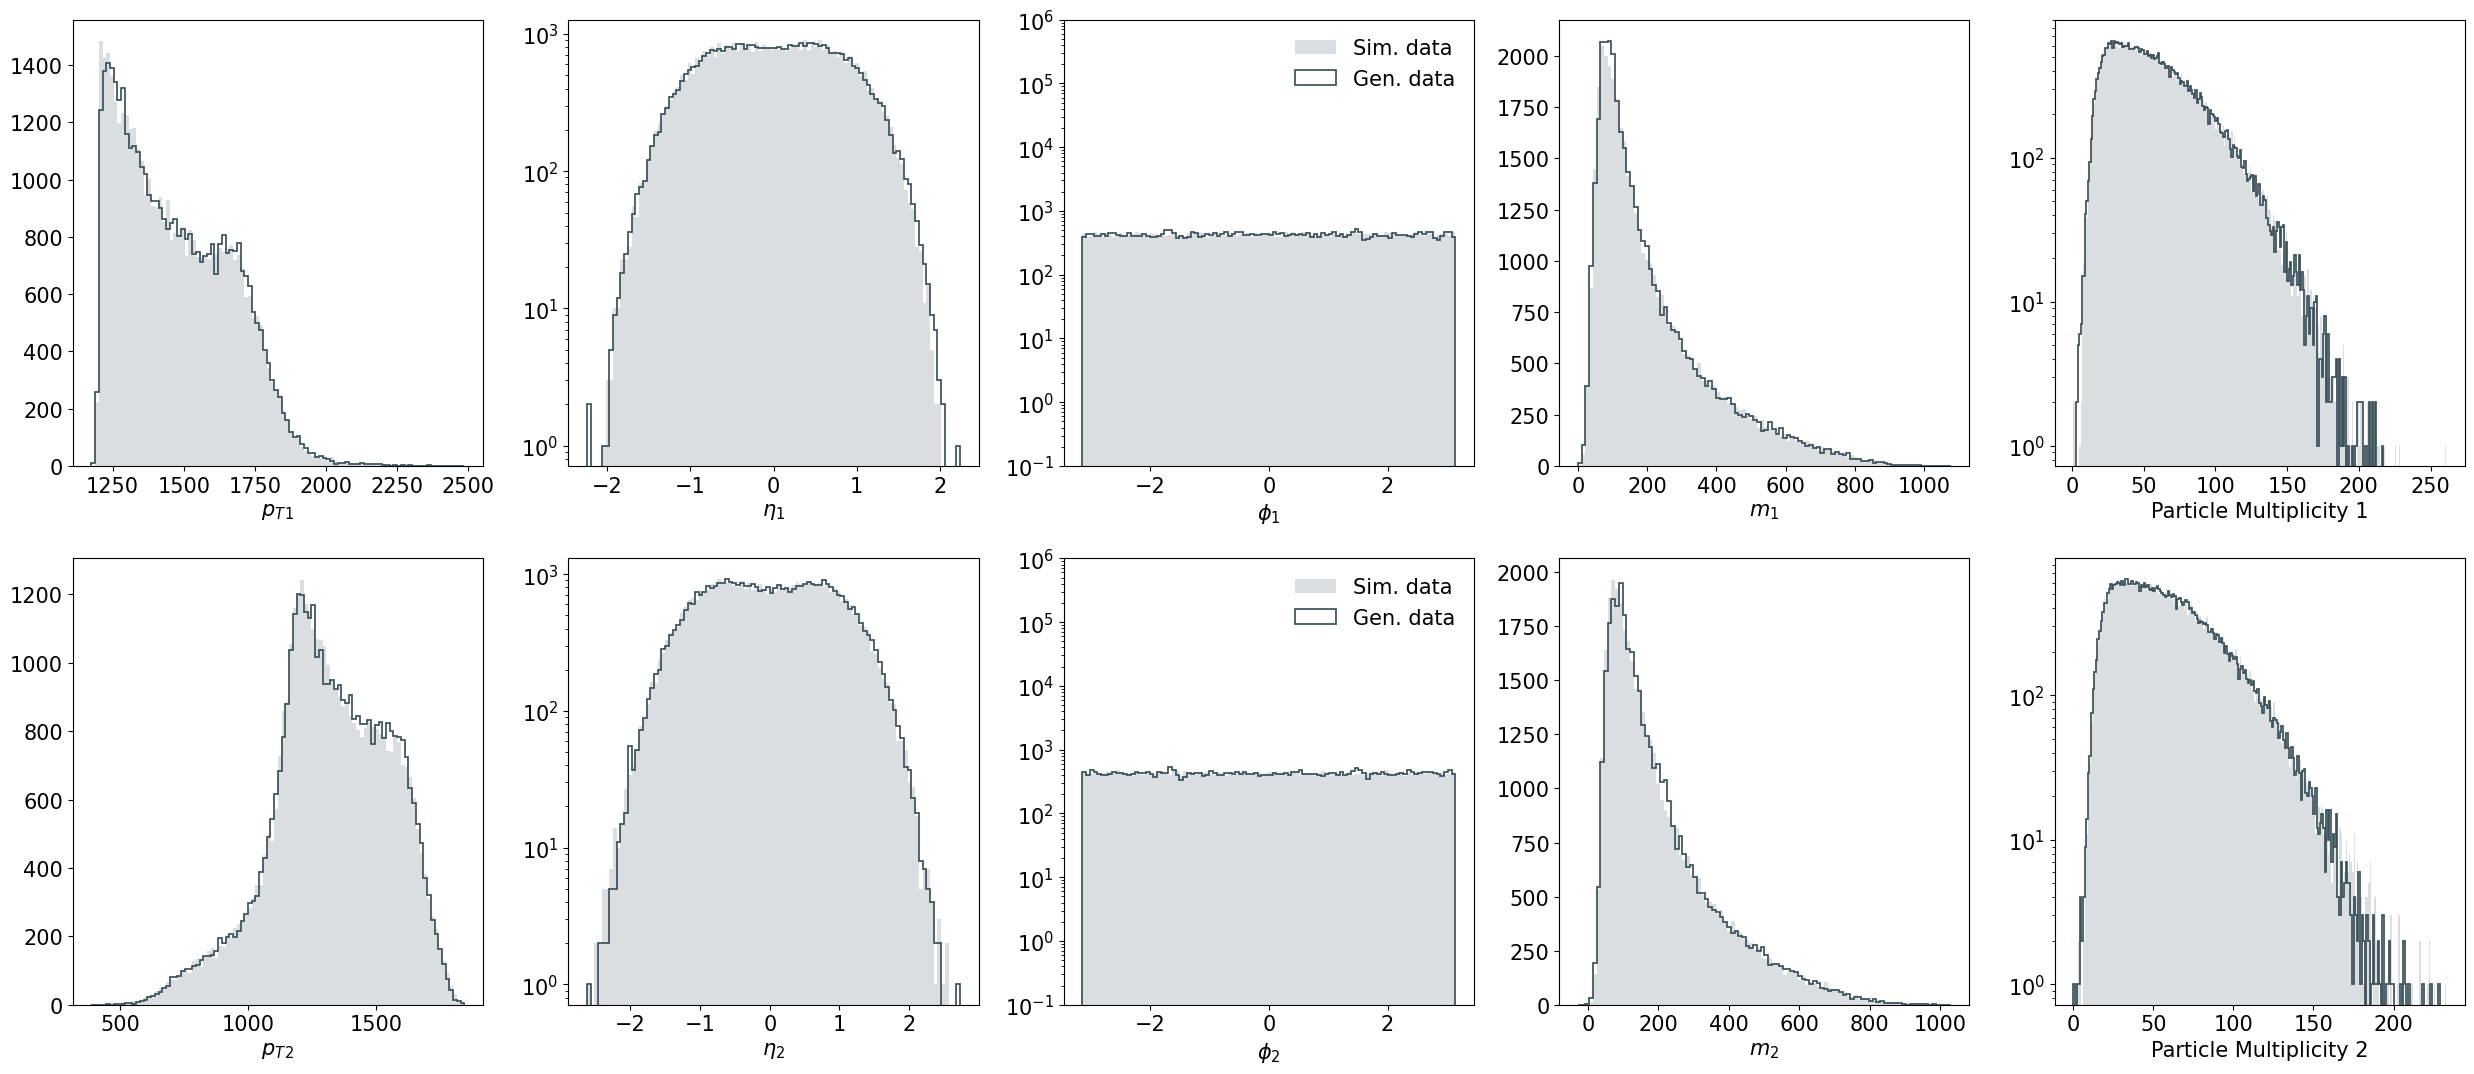

In [96]:
plot_samples = min(n_samples, len(test_data_sr))
label_map = {
    "0": r"${p_T}_1$",
    "1": r"$\eta_1$",
    "2": r"$\phi_1$",
    "3": r"$m_1$",
    "4": "Particle Multiplicity 1",
    "5": r"${p_T}_2$",
    "6": r"$\eta_2$",
    "7": r"$\phi_2$",
    "8": r"$m_2$",
    "9": "Particle Multiplicity 2",
}
fig, axs = plt.subplots(2, 5, figsize=(25, 11))
for index, ax in enumerate(axs.reshape(-1)):
    x_min, x_max = min(
        np.min(test_data_sr[:plot_samples, index]), np.min(data_jet_feature[:plot_samples, index])
    ), max(
        np.max(test_data_sr[:plot_samples, index]), np.max(data_jet_feature[:plot_samples, index])
    )
    if index == 4 or index == 9:
        bin_width = 1
        bins = range(int(x_min), int(x_max) + bin_width, bin_width)
    else:
        bins = 100
    hist1 = ax.hist(
        test_data_sr[:plot_samples, index],
        bins=bins,
        label="Sim. data",
        range=[x_min, x_max],
        alpha=0.5,
    )
    ax.hist(
        data_jet_feature[:plot_samples, index], bins=hist1[1], label="Gen. data", histtype="step"
    )
    ax.set_xlabel(f"{label_map[str(index)]}")
    if index == 1 or index == 2 or index == 4 or index == 6 or index == 7 or index == 9:
        ax.set_yscale("log")
    if index == 2 or index == 7:
        ax.legend(frameon=False)
        ax.set_ylim(1e-1, 1e6)
plt.tight_layout()
# plt.suptitle("Signal Region", fontsize=30)
# fig.subplots_adjust(top=0.93)
plt.show()

# Particle Feature Model

### Load Models

In [ ]:
experiment_x = "/lhco/lhco_x_jet.yaml"
experiment_y = "/lhco/lhco_y_jet.yaml"

In [ ]:
# load everything from experiment config
with hydra.initialize(version_base=None, config_path="../configs/"):
    cfg_x = hydra.compose(config_name="train.yaml", overrides=[f"experiment={experiment_x}"])
    # print(OmegaConf.to_yaml(cfg_x))

In [ ]:
# load everything from experiment config
with hydra.initialize(version_base=None, config_path="../configs/"):
    cfg_y = hydra.compose(config_name="train.yaml", overrides=[f"experiment={experiment_y}"])
    # print(OmegaConf.to_yaml(cfg_y))

In [ ]:
datamodule_x = hydra.utils.instantiate(cfg_x.data)
model_x = hydra.utils.instantiate(cfg_x.model)

In [ ]:
datamodule_y = hydra.utils.instantiate(cfg_y.data)
model_y = hydra.utils.instantiate(cfg_y.model)

In [ ]:
datamodule_x.setup()

In [ ]:
datamodule_y.setup()

### Load checkpoint

In [ ]:
ckpt_x = (
    "/beegfs/desy/user/ewencedr/deep-learning/logs/lhco x jet mass new cut"
    " interpolate/runs/2023-08-16_02-00-37/checkpoints/last-EMA.ckpt"
)
model_x = model_x.load_from_checkpoint(ckpt_x)

In [ ]:
ckpt_y = (
    "/beegfs/desy/user/ewencedr/deep-learning/logs/lhco y jet mass new cut"
    " interpolate/runs/2023-08-16_03-49-00/checkpoints/epoch_2717_loss_16.28091-EMA.ckpt"
)
model_y = model_y.load_from_checkpoint(ckpt_y)

### Generate Data

In [ ]:
n_samples_x = n_samples
n_samples_y = n_samples

In [ ]:
# normalize conditioning variables
cond_x = data_jet_feature[:, 0:4]
normalized_cond_x = normalize_tensor(
    torch.tensor(cond_x, dtype=torch.float32).clone(),
    datamodule_x.cond_means,
    datamodule_x.cond_stds,
    datamodule_x.hparams.normalize_sigma,
)

In [ ]:
# normalize conditioning variables
cond_y = data_jet_feature[:, 5:9]
normalized_cond_y = normalize_tensor(
    torch.tensor(cond_y, dtype=torch.float32).clone(),
    datamodule_y.cond_means,
    datamodule_y.cond_stds,
    datamodule_y.hparams.normalize_sigma,
)

In [ ]:
mask_x_ints = data_jet_feature[:, 4]

In [ ]:
mask_y_ints = data_jet_feature[:, 9]

In [ ]:
n_classes_x = datamodule_x.tensor_test.shape[1]
targets_x = np.rint(mask_x_ints).astype(int)
mask_x = np.expand_dims(np.tril(np.ones((n_classes_x, n_classes_x)), k=-1)[targets_x], axis=-1)

In [ ]:
n_classes_y = datamodule_y.tensor_test.shape[1]
targets_y = np.rint(mask_y_ints).astype(int)
mask_y = np.expand_dims(np.tril(np.ones((n_classes_y, n_classes_y)), k=-1)[targets_y], axis=-1)

In [ ]:
torch.manual_seed(9999)
data_x, generation_time_x = generate_data(
    model_x,
    num_jet_samples=n_samples_x,
    batch_size=2048,
    cond=normalized_cond_x[:n_samples_x],
    variable_set_sizes=datamodule_x.hparams.variable_jet_sizes,
    mask=torch.tensor(mask_x, dtype=torch.int64),
    normalized_data=datamodule_x.hparams.normalize,
    means=datamodule_x.means,
    stds=datamodule_x.stds,
    ode_solver="midpoint",
    ode_steps=200,
)

In [ ]:
path_x = f"{data_folder}/lhco/generated/x_data.h5"

In [ ]:
# with h5py.File(path_x, "w") as f:
#    f.create_dataset("data", data=data_x)
#    f.create_dataset("generation_time", data=generation_time_x)
#    f.create_dataset("mask", data=mask_x)
#    f.create_dataset("cond", data=cond_x)
#    f.create_dataset("normalized_cond", data=normalized_cond_x)
#    f.create_dataset("mjj", data=mjj_samples_sr)

In [ ]:
with h5py.File(path_x, "r") as f:
    data_x = f["data"][:]

In [ ]:
print(data_x.shape)

In [ ]:
torch.manual_seed(9999)
data_y, generation_time_y = generate_data(
    model_y,
    num_jet_samples=n_samples_y,
    batch_size=2048,
    cond=normalized_cond_y[:n_samples_y],
    variable_set_sizes=datamodule_y.hparams.variable_jet_sizes,
    mask=torch.tensor(mask_y, dtype=torch.int64),
    normalized_data=datamodule_y.hparams.normalize,
    means=datamodule_y.means,
    stds=datamodule_y.stds,
    ode_solver="midpoint",
    ode_steps=200,
)

In [ ]:
path_y = f"{data_folder}/lhco/generated/y_data.h5"

In [ ]:
# with h5py.File(path_y, "w") as f:
#    f.create_dataset("data", data=data_y)
#    f.create_dataset("generation_time", data=generation_time_y)
#    f.create_dataset("mask", data=mask_y)
#    f.create_dataset("cond", data=cond_y)
#    f.create_dataset("normalized_cond", data=normalized_cond_y)
#    f.create_dataset("mjj", data=mjj_samples_sr)

In [ ]:
with h5py.File(path_y, "r") as f:
    data_y = f["data"][:]

In [ ]:
print(data_y.shape)

In [ ]:
print(np.sum(data_x[:, :, 2] > 1))

In [ ]:
np.min(data_y[:, :, 2][data_y[:, :, 2] > 0.0])

remove unphysical values

In [ ]:
data_x[data_x[:, :, 2] < 0] = np.min(
    datamodule_x.tensor_train.numpy()[:, :, 2][datamodule_x.tensor_train.numpy()[:, :, 2] > 0.0]
)
data_x[data_x[:, :, 2] > 1] = np.max(
    datamodule_x.tensor_train.numpy()[:, :, 2][datamodule_x.tensor_train.numpy()[:, :, 2] < 1.0]
)

In [ ]:
data_y[data_y[:, :, 2] < 0] = np.min(
    datamodule_y.tensor_train.numpy()[:, :, 2][datamodule_y.tensor_train.numpy()[:, :, 2] > 0.0]
)
data_y[data_y[:, :, 2] > 1] = np.max(
    datamodule_y.tensor_train.numpy()[:, :, 2][datamodule_y.tensor_train.numpy()[:, :, 2] < 1.0]
)

In [ ]:
print(data_x.shape)
print(np.sum(data_x[:, :, 2] < 0))
print(np.sum(data_x[:, :, 2] > 1))

### Save generated data

In [ ]:
path_final_rel = f"{data_folder}/lhco/generated/final_rel_data.h5"

In [ ]:
print(data_x.shape)
print(data_y.shape)
print(data_jet_feature[:, :5].shape)
print(data_jet_feature[:, 5:].shape)
print(mjj_samples_sr.shape)

In [ ]:
# with h5py.File(path_final_rel, "w") as f:
#    f.create_dataset("particle_data_rel_x", data=data_x)
#    f.create_dataset("particle_data_rel_y", data=data_y)
#    f.create_dataset("jet_features_x", data=data_jet_feature[:, :5])
#    f.create_dataset("jet_features_y", data=data_jet_feature[:, 5:])
#    f.create_dataset("mjj", data=mjj_samples_sr)

In [ ]:
with h5py.File(path_final_rel, "r") as f:
    data_x = f["particle_data_rel_x"][:]
    data_y = f["particle_data_rel_y"][:]

### Plots

In [ ]:
background_data_x = np.array(datamodule_x.tensor_test_sr[: len(data_x)])

In [ ]:
background_data_y = np.array(datamodule_y.tensor_test_sr[: len(data_y)])

In [ ]:
print(data_x.shape)
print(background_data_x.shape)

In [ ]:
plot_config_x = {
    "num_samples": min(len(data_x), len(background_data_x)),
    "plot_jet_features": False,
    "plot_w_dists": False,
    "plot_efps": True,
    "plot_selected_multiplicities": False,
    "selected_multiplicities": [10, 20, 30, 40, 50, 100],
    "selected_particles": [1, 5, 20],
    "plottype": "",
    "save_fig": False,
    "variable_jet_sizes_plotting": True,
    "bins": 100,
    "close_fig": False,
}
plot_prep_config_x = {
    "calculate_efps" if key == "plot_efps" else key: value
    for key, value in plot_config_x.items()
    if key in ["plot_efps", "selected_particles", "selected_multiplicities"]
}

In [ ]:
plot_config_y = {
    "num_samples": min(len(data_y), len(background_data_y)),
    "plot_jet_features": False,
    "plot_w_dists": False,
    "plot_efps": True,
    "plot_selected_multiplicities": False,
    "selected_multiplicities": [10, 20, 30, 40, 50, 100],
    "selected_particles": [1, 5, 20],
    "plottype": "",
    "save_fig": False,
    "variable_jet_sizes_plotting": True,
    "bins": 100,
    "close_fig": False,
}
plot_prep_config_y = {
    "calculate_efps" if key == "plot_efps" else key: value
    for key, value in plot_config_y.items()
    if key in ["plot_efps", "selected_particles", "selected_multiplicities"]
}

In [ ]:
(
    jet_data_x,
    efps_values_x,
    pt_selected_particles_x,
    pt_selected_multiplicities_x,
) = prepare_data_for_plotting(
    np.array([data_x[: len(background_data_x)]]),
    **plot_prep_config_x,
)

In [ ]:
(
    jet_data_y,
    efps_values_y,
    pt_selected_particles_y,
    pt_selected_multiplicities_y,
) = prepare_data_for_plotting(
    np.array([data_y[: len(background_data_y)]]),
    **plot_prep_config_y,
)

In [ ]:
(
    jet_data_sim_x,
    efps_sim_x,
    pt_selected_particles_sim_x,
    pt_selected_multiplicities_sim_x,
) = prepare_data_for_plotting(
    [background_data_x],
    **plot_prep_config_x,
)
jet_data_sim_x, efps_sim_x, pt_selected_particles_sim_x = (
    jet_data_sim_x[0],
    efps_sim_x[0],
    pt_selected_particles_sim_x[0],
)

In [ ]:
(
    jet_data_sim_y,
    efps_sim_y,
    pt_selected_particles_sim_y,
    pt_selected_multiplicities_sim_y,
) = prepare_data_for_plotting(
    [background_data_y],
    **plot_prep_config_y,
)
jet_data_sim_y, efps_sim_y, pt_selected_particles_sim_y = (
    jet_data_sim_y[0],
    efps_sim_y[0],
    pt_selected_particles_sim_y[0],
)

In [ ]:
print(efps_sim_x.shape)
print(np.concatenate(efps_sim_x).shape)

In [ ]:
fig_x = plot_data(
    particle_data=np.array([data_x[: len(background_data_x)]]),
    sim_data=background_data_x,
    jet_data_sim=jet_data_sim_x,
    jet_data=jet_data_x,
    efps_sim=efps_sim_x,
    efps_values=efps_values_x,
    pt_selected_particles=pt_selected_particles_x,
    pt_selected_multiplicities=pt_selected_multiplicities_x,
    pt_selected_particles_sim=pt_selected_particles_sim_x,
    pt_selected_multiplicities_sim=pt_selected_multiplicities_sim_x,
    **plot_config_x,
)

In [ ]:
fig_y = plot_data(
    particle_data=np.array([data_y[: len(background_data_y)]]),
    sim_data=background_data_y,
    jet_data_sim=jet_data_sim_y,
    jet_data=jet_data_y,
    efps_sim=efps_sim_y,
    efps_values=efps_values_y,
    pt_selected_particles=pt_selected_particles_y,
    pt_selected_multiplicities=pt_selected_multiplicities_y,
    pt_selected_particles_sim=pt_selected_particles_sim_y,
    pt_selected_multiplicities_sim=pt_selected_multiplicities_sim_y,
    **plot_config_y,
)

### Back to non-rel. Coordinates

conditioning from feature model to recalculate the nonrel coordinates of the generated particles

In [ ]:
pt_x = cond_x[:, 0].reshape(-1, 1)
eta_x = cond_x[:, 1].reshape(-1, 1)
phi_x = cond_x[:, 2].reshape(-1, 1)
m_x = cond_x[:, 3].reshape(-1, 1)

In [ ]:
pt_y = cond_y[:, 0].reshape(-1, 1)
eta_y = cond_y[:, 1].reshape(-1, 1)
phi_y = cond_y[:, 2].reshape(-1, 1)
m_y = cond_y[:, 3].reshape(-1, 1)

In [ ]:
mask_x_nonrel = np.expand_dims((data_x[..., 2] > 0).astype(int), axis=-1)
non_rel_eta_x = np.expand_dims(data_x.copy()[:, :, 0] + eta_x, axis=-1)
non_rel_phi_x = np.expand_dims(data_x.copy()[:, :, 1] + phi_x, axis=-1)
# wrap phi between -pi and pi
non_rel_phi_x = np.where(
    non_rel_phi_x > np.pi,
    non_rel_phi_x - 2 * np.pi,
    non_rel_phi_x,
)
non_rel_phi_x = np.where(
    non_rel_phi_x < -np.pi,
    non_rel_phi_x + 2 * np.pi,
    non_rel_phi_x,
)
non_rel_pt_x = np.expand_dims(data_x.copy()[:, :, 2] * pt_x, axis=-1)
# fix the masking
non_rel_eta_x = non_rel_eta_x * mask_x_nonrel
non_rel_phi_x = non_rel_phi_x * mask_x_nonrel
data_x_nonrel = np.concatenate([non_rel_eta_x, non_rel_phi_x, non_rel_pt_x], axis=-1)

In [ ]:
mask_y_nonrel = np.expand_dims((data_y[..., 2] > 0).astype(int), axis=-1)
non_rel_eta_y = np.expand_dims(data_y.copy()[:, :, 0] + eta_y, axis=-1)
non_rel_phi_y = np.expand_dims(data_y.copy()[:, :, 1] + phi_y, axis=-1)
# wrap phi between -pi and pi
non_rel_phi_y = np.where(
    non_rel_phi_y > np.pi,
    non_rel_phi_y - 2 * np.pi,
    non_rel_phi_y,
)
non_rel_phi_y = np.where(
    non_rel_phi_y < -np.pi,
    non_rel_phi_y + 2 * np.pi,
    non_rel_phi_y,
)
non_rel_pt_y = np.expand_dims(data_y.copy()[:, :, 2] * pt_y, axis=-1)
# fix the masking
non_rel_eta_y = non_rel_eta_y * mask_y_nonrel
non_rel_phi_y = non_rel_phi_y * mask_y_nonrel
data_y_nonrel = np.concatenate([non_rel_eta_y, non_rel_phi_y, non_rel_pt_y], axis=-1)

load non rel. data and select the same events that were generated

In [ ]:
path_nonrel = f"{data_folder}/lhco/final_data/processed_data_background.h5"
with h5py.File(path_nonrel, "r") as f:
    particle_data_nonrel = f["constituents"][:]

In [ ]:
particle_data_nonrel_sr = particle_data_nonrel[args_to_keep_sr]

In [ ]:
n_samples_val_sr_x = int(datamodule_x.hparams.val_fraction * len(particle_data_nonrel_sr))
n_samples_test_sr_x = int(datamodule_x.hparams.test_fraction * len(particle_data_nonrel_sr))

In [ ]:
particle_data_nonrel_sr_train, particle_data_nonrel_sr_val, particle_data_nonrel_sr_test = (
    np.split(
        particle_data_nonrel_sr,
        [
            len(particle_data_nonrel_sr) - (n_samples_val_sr_x + n_samples_test_sr_x),
            len(particle_data_nonrel_sr) - n_samples_test_sr_x,
        ],
    )
)

In [ ]:
background_data_x_nonrel = particle_data_nonrel_sr_test[: len(data_x_nonrel), 0]
background_data_x_nonrel = background_data_x_nonrel[:, :, [1, 2, 0]]

In [ ]:
background_data_y_nonrel = particle_data_nonrel_sr_test[: len(data_y_nonrel), 1]
background_data_y_nonrel = background_data_y_nonrel[:, :, [1, 2, 0]]

In [ ]:
plot_config_x_nonrel = {
    "num_samples": -1,
    "plot_jet_features": True,
    "plot_w_dists": False,
    "plot_efps": True,
    "plot_selected_multiplicities": False,
    "selected_multiplicities": [10, 20, 30, 40, 50, 100],
    "selected_particles": [1, 3, 10],
    "plottype": "",
    "save_fig": False,
    "variable_jet_sizes_plotting": True,
    "bins": 100,
    "close_fig": False,
    "mass_linear": True,
    "plot_xlabels": [
        r"Particle $p_\mathrm{T}$",
        r"Particle $\eta$",
        r"Particle $\phi$",
        r"Jet $p_\mathrm{T}$",
    ],
}
plot_prep_config_x_nonrel = {
    "calculate_efps" if key == "plot_efps" else key: value
    for key, value in plot_config_x_nonrel.items()
    if key in ["plot_efps", "selected_particles", "selected_multiplicities"]
}

In [ ]:
plot_config_y_nonrel = {
    "num_samples": -1,
    "plot_jet_features": True,
    "plot_w_dists": False,
    "plot_efps": True,
    "plot_selected_multiplicities": False,
    "selected_multiplicities": [10, 20, 30, 40, 50, 100],
    "selected_particles": [1, 3, 10],
    "plottype": "",
    "save_fig": False,
    "variable_jet_sizes_plotting": True,
    "bins": 100,
    "close_fig": False,
    "mass_linear": True,
    "plot_xlabels": [
        r"Particle $p_\mathrm{T}$",
        r"Particle $\eta$",
        r"Particle $\phi$",
        r"Jet $p_\mathrm{T}$",
    ],
}
plot_prep_config_y_nonrel = {
    "calculate_efps" if key == "plot_efps" else key: value
    for key, value in plot_config_y_nonrel.items()
    if key in ["plot_efps", "selected_particles", "selected_multiplicities"]
}

In [ ]:
(
    jet_data_x_nonrel,
    efps_values_x_nonrel,
    pt_selected_particles_x_nonrel,
    pt_selected_multiplicities_x_nonrel,
) = prepare_data_for_plotting(
    np.array([data_x_nonrel[: len(background_data_x_nonrel)]]),
    **plot_prep_config_x_nonrel,
)

In [ ]:
(
    jet_data_y_nonrel,
    efps_values_y_nonrel,
    pt_selected_particles_y_nonrel,
    pt_selected_multiplicities_y_nonrel,
) = prepare_data_for_plotting(
    np.array([data_y_nonrel[: len(background_data_y_nonrel)]]),
    **plot_prep_config_y_nonrel,
)

In [ ]:
(
    jet_data_sim_x_nonrel,
    efps_sim_x_nonrel,
    pt_selected_particles_sim_x_nonrel,
    pt_selected_multiplicities_sim_x_nonrel,
) = prepare_data_for_plotting(
    [background_data_x_nonrel],
    **plot_prep_config_x_nonrel,
)
jet_data_sim_x_nonrel, efps_sim_x_nonrel, pt_selected_particles_sim_x_nonrel = (
    jet_data_sim_x_nonrel[0],
    efps_sim_x_nonrel[0],
    pt_selected_particles_sim_x_nonrel[0],
)

In [ ]:
(
    jet_data_sim_y_nonrel,
    efps_sim_y_nonrel,
    pt_selected_particles_sim_y_nonrel,
    pt_selected_multiplicities_sim_y_nonrel,
) = prepare_data_for_plotting(
    [background_data_y_nonrel],
    **plot_prep_config_y_nonrel,
)
jet_data_sim_y_nonrel, efps_sim_y_nonrel, pt_selected_particles_sim_y_nonrel = (
    jet_data_sim_y_nonrel[0],
    efps_sim_y_nonrel[0],
    pt_selected_particles_sim_y_nonrel[0],
)

In [ ]:
fig_x_nonrel = plot_data(
    particle_data=np.array([data_x_nonrel[: len(background_data_x_nonrel)]]),
    sim_data=background_data_x_nonrel,
    jet_data_sim=jet_data_sim_x_nonrel,
    jet_data=jet_data_x_nonrel,
    efps_sim=efps_sim_x_nonrel,
    efps_values=efps_values_x_nonrel,
    pt_selected_particles=pt_selected_particles_x_nonrel,
    pt_selected_multiplicities=pt_selected_multiplicities_x_nonrel,
    pt_selected_particles_sim=pt_selected_particles_sim_x_nonrel,
    pt_selected_multiplicities_sim=pt_selected_multiplicities_sim_x_nonrel,
    **plot_config_x_nonrel,
)

In [ ]:
fig_y_nonrel = plot_data(
    particle_data=np.array([data_y_nonrel[: len(background_data_y_nonrel)]]),
    sim_data=background_data_y_nonrel,
    jet_data_sim=jet_data_sim_y_nonrel,
    jet_data=jet_data_y_nonrel,
    efps_sim=efps_sim_y_nonrel,
    efps_values=efps_values_y_nonrel,
    pt_selected_particles=pt_selected_particles_y_nonrel,
    pt_selected_multiplicities=pt_selected_multiplicities_y_nonrel,
    pt_selected_particles_sim=pt_selected_particles_sim_y_nonrel,
    pt_selected_multiplicities_sim=pt_selected_multiplicities_sim_y_nonrel,
    **plot_config_y_nonrel,
)

# Save generated data to file

In [ ]:
path_final_all = f"{data_folder}/lhco/generated/final_data_all.h5"

In [ ]:
print(data_x.shape)
print(data_y.shape)
print(data_x_nonrel.shape)
print(data_y_nonrel.shape)
print(data_jet_feature[:, :5].shape)
print(data_jet_feature[:, 5:].shape)
print(mjj_samples_sr.shape)

In [ ]:
with h5py.File(path_final_all, "w") as f:
    f.create_dataset("particle_data_rel_x", data=data_x)
    f.create_dataset("particle_data_rel_y", data=data_y)
    f.create_dataset("particle_data_nonrel_x", data=data_x_nonrel)
    f.create_dataset("particle_data_nonrel_y", data=data_y_nonrel)
    f.create_dataset("jet_features_x", data=data_jet_feature[:, :5])
    f.create_dataset("jet_features_y", data=data_jet_feature[:, 5:])
    f.create_dataset("mjj", data=mjj_samples_sr)

## combine both jets

In [ ]:
data_x_nonrel_ptetaphi = data_x_nonrel[:, :, [2, 0, 1]]
data_y_nonrel_ptetaphi = data_x_nonrel[:, :, [2, 0, 1]]

In [ ]:
data_combined = np.concatenate((data_x_nonrel_ptetaphi, data_y_nonrel_ptetaphi), axis=1)
print(data_combined.shape)

In [ ]:
padded_data = np.pad(
    data_combined,
    ((0, 0), (0, 700 - data_combined.shape[1]), (0, 0)),
    "constant",
    constant_values=0,
)
print(padded_data.shape)

In [ ]:
final_data = np.reshape(padded_data, (padded_data.shape[0], -1))
print(final_data.shape)

In [ ]:
import pandas as pd

In [ ]:
final_path = f"{data_folder}/lhco/generated/final_data.h5"
df_final = pd.DataFrame(data=final_data)
df_final.to_hdf(final_path, key="df", mode="w")

In [ ]:
filepath = f"{data_folder}/lhco/events_anomalydetection_v2.h5"

In [ ]:
# Load everything into memory
df = pd.read_hdf(filepath)
print(df.shape)
print("Memory in GB:", sum(df.memory_usage(deep=True)) / (1024**3))

# Evaluation

In [ ]:
with h5py.File(path_final_all, "r") as f:
    eval_x_rel = f["particle_data_rel_x"][:]
    eval_y_rel = f["particle_data_rel_y"][:]
    eval_x_nonrel = f["particle_data_nonrel_x"][:]
    eval_y_nonrel = f["particle_data_nonrel_y"][:]
    eval_jet_features_x = f["jet_features_x"][:]
    eval_jet_features_y = f["jet_features_y"][:]
    eval_mjj = f["mjj"][:]

In [ ]:
def get_jet_data(consts: np.ndarray) -> np.ndarray:
    """Calculate jet data from constituent data. (pt, y, phi)->(pt, y, phi, m)

    Args:
        consts (np.ndarray): constituent data. (pt, y, phi)

    Returns:
        np.ndarray: jet data. (pt, y, phi, m)
    """
    p4s = ef.p4s_from_ptyphims(consts[..., :3])
    sum_p4 = np.sum(p4s, axis=-2)
    jet_data = ef.ptyphims_from_p4s(sum_p4, phi_ref=0)
    return jet_data

In [ ]:
eval_x_rel = eval_x_rel[:, :, [2, 0, 1]]
eval_y_rel = eval_y_rel[:, :, [2, 0, 1]]
eval_x_nonrel = eval_x_nonrel[:, :, [2, 0, 1]]
eval_y_nonrel = eval_y_nonrel[:, :, [2, 0, 1]]
print(eval_x_rel.shape)

In [ ]:
eval_jet_data_x = get_jet_data(eval_x_rel)
eval_jet_data_y = get_jet_data(eval_y_rel)
eval_jet_data_x_nonrel = get_jet_data(eval_x_nonrel)
eval_jet_data_y_nonrel = get_jet_data(eval_y_nonrel)

In [ ]:
print(eval_jet_data_x[:, -1].shape)
print(eval_jet_features_x[:, -1].shape)

In [ ]:
datamodule_x.cond_means.shape

In [ ]:
# normalize conditioning variables
eval_normalized_cond_x = normalize_tensor(
    torch.tensor(eval_jet_features_x[:, :4], dtype=torch.float32).clone(),
    datamodule_x.cond_means,
    datamodule_x.cond_stds,
    datamodule_x.hparams.normalize_sigma,
).numpy()

In [ ]:
eval_normalized_cond_x.shape

In [ ]:
labels = ["pt", "eta", "phi", "mass"]
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axs):
    max_v = max(np.max(eval_normalized_cond_x[:, i]), np.max(eval_normalized_cond_x[:, i]))
    min_v = min(np.min(eval_normalized_cond_x[:, i]), np.min(eval_normalized_cond_x[:, i]))

    ax.hist2d(
        eval_normalized_cond_x[:, i],
        eval_jet_data_x[:, i],
        bins=50,
        range=[[min_v, max_v], [min_v, max_v]],
        cmap="jet",
    )
    ax.set_xlabel(f"{labels[i]} conditioning")
    ax.set_ylabel(f"{labels[i]} generated")
    ax.set_title("higher mass jet rel")
plt.tight_layout()
plt.plot()

In [ ]:
max_v = max(np.max(eval_jet_features_x[:, -2]), np.max(eval_jet_features_x[:, -2]))
min_v = min(np.min(eval_jet_features_x[:, -2]), np.min(eval_jet_features_x[:, -2]))

plt.hist2d(
    eval_jet_features_x[:, -2],
    eval_jet_features_x[:, -2],
    bins=100,
    range=[[min_v, max_v], [min_v, max_v]],
    cmap="jet",
)
plt.xlabel("Jet mass conditioning")
plt.ylabel("Jet mass generated")
plt.title("ref.")
plt.plot()

In [ ]:
max_v = max(np.max(eval_jet_features_x[:, -2]), np.max(eval_jet_features_x[:, -2]))
min_v = min(np.min(eval_jet_features_x[:, -2]), np.min(eval_jet_features_x[:, -2]))

plt.hist2d(
    eval_jet_features_x[:, -2],
    eval_jet_data_x[:, -1],
    bins=100,
    range=[[min_v, max_v], [min_v, max_v]],
    cmap="jet",
)
plt.xlabel("Jet mass conditioning")
plt.ylabel("Jet mass generated")
plt.title("rel.")
plt.plot()

In [ ]:
labels = ["pt", "eta", "phi", "mass"]
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axs):
    max_v = max(np.max(eval_jet_features_x[:, i]), np.max(eval_jet_features_x[:, i]))
    min_v = min(np.min(eval_jet_features_x[:, i]), np.min(eval_jet_features_x[:, i]))

    ax.hist2d(
        eval_jet_features_x[:, i],
        eval_jet_data_x_nonrel[:, i],
        bins=50,
        range=[[min_v, max_v], [min_v, max_v]],
        cmap="jet",
    )
    ax.set_xlabel(f"{labels[i]} conditioning")
    ax.set_ylabel(f"{labels[i]} generated")
    ax.set_title("higher mass jet")
plt.tight_layout()
plt.plot()

In [ ]:
max_v = max(np.max(eval_jet_features_y[:, -2]), np.max(eval_jet_features_y[:, -2]))
min_v = min(np.min(eval_jet_features_y[:, -2]), np.min(eval_jet_features_y[:, -2]))

plt.hist2d(
    eval_jet_features_y[:, -2],
    eval_jet_features_y[:, -2],
    bins=100,
    range=[[min_v, max_v], [min_v, max_v]],
    cmap="jet",
)
plt.xlabel("Jet mass conditioning")
plt.ylabel("Jet mass generated")
plt.title("ref. y")
plt.plot()

In [ ]:
max_v = max(np.max(eval_jet_features_y[:, -2]), np.max(eval_jet_features_y[:, -2]))
min_v = min(np.min(eval_jet_features_y[:, -2]), np.min(eval_jet_features_y[:, -2]))

plt.hist2d(
    eval_jet_features_y[:, -2],
    eval_jet_data_y[:, -1],
    bins=100,
    range=[[min_v, max_v], [min_v, max_v]],
    cmap="jet",
)
plt.xlabel("Jet mass conditioning")
plt.ylabel("Jet mass generated")
plt.title("rel.")
plt.plot()

In [ ]:
labels = ["pt", "eta", "phi", "mass"]
fig, axs = plt.subplots(1, 4, figsize=(20, 5))
for i, ax in enumerate(axs):
    max_v = max(np.max(eval_jet_features_y[:, i]), np.max(eval_jet_features_y[:, i]))
    min_v = min(np.min(eval_jet_features_y[:, i]), np.min(eval_jet_features_y[:, i]))

    ax.hist2d(
        eval_jet_features_y[:, i],
        eval_jet_data_y_nonrel[:, i],
        bins=50,
        range=[[min_v, max_v], [min_v, max_v]],
        cmap="jet",
    )
    ax.set_xlabel(f"{labels[i]} conditioning")
    ax.set_ylabel(f"{labels[i]} generated")
    ax.set_title("lighter mass jet")
plt.tight_layout()
plt.plot()

# plot stuff

In [98]:
path_g = "/beegfs/desy/user/ewencedr/data/lhco/generated/lhco-xy-10layer-256latent-logpt-noseed-cond_sr-midpoint-250.h5"

In [104]:
with h5py.File(path_g, "r") as f:
    data_particle = f["particle_features"][:]
    data_raw = f["data_raw"][:]
    data_jet_feature = f["jet_features"][:]

In [107]:
print(data_particle.shape)
print(data_raw.shape)

(200000, 2, 279, 3)
(200000, 2, 279, 3)


In [121]:
#np.count_nonzero(np.isnan(data_raw))
np.where(np.isnan(data_raw))
np.unique(np.where(np.isnan(data_raw))[0])

array([ 34491, 108474])

In [127]:
print(data_jet_feature[34491,1])
print(data_jet_feature[34490,1])
print(data_jet_feature[34492,1])
print(data_jet_feature[108474,1])



[812.58032227  -2.06599998  -1.78135538 -28.09353638 279.        ]
[ 1.36678540e+03 -2.87862778e-01  3.31885517e-01  3.45126953e+02
  5.20000000e+01]
[ 1.21849854e+03  5.55140197e-01 -4.01636839e-01  1.14109093e+02
  5.20000000e+01]
[ 1.20328113e+03 -4.13754702e-01  2.61715412e+00  2.58216553e+01
  2.79000000e+02]


In [120]:
print(data_raw[34491, 1, :])

[[nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan nan]
 [nan nan 

In [13]:
directory = "/beegfs/desy/user/ewencedr/data/lhco/final_data/Output_DelphesPythia8_AnomalyDetection_v2_qcd_inneronly"
files = os.listdir(directory)
print(files)

['events_DelphesPythia8_qcd_nompi_10839_inner_4vecs_and_features.npy', 'events_DelphesPythia8_qcd_nompi_12878_inner_4vecs_and_features.npy', 'events_DelphesPythia8_qcd_nompi_10497_inner_4vecs_and_features.npy', 'events_DelphesPythia8_qcd_nompi_10180_inner_4vecs_and_features.npy', 'events_DelphesPythia8_qcd_nompi_11783_inner_4vecs_and_features.npy', 'events_DelphesPythia8_qcd_nompi_11150_inner_4vecs_and_features.npy', 'events_DelphesPythia8_qcd_nompi_10979_inner_4vecs_and_features.npy', 'events_DelphesPythia8_qcd_nompi_11044_inner_4vecs_and_features.npy', 'events_DelphesPythia8_qcd_nompi_11216_inner_4vecs_and_features.npy', 'events_DelphesPythia8_qcd_nompi_12072_inner_4vecs_and_features.npy', 'events_DelphesPythia8_qcd_nompi_12903_inner_4vecs_and_features.npy', 'events_DelphesPythia8_qcd_nompi_11073_inner_4vecs_and_features.npy', 'events_DelphesPythia8_qcd_nompi_11729_inner_4vecs_and_features.npy', 'events_DelphesPythia8_qcd_nompi_10691_inner_4vecs_and_features.npy', 'events_DelphesPyth

In [19]:
from tqdm import tqdm
full_data = []
for file in tqdm(files):
    data_temp = np.load(f"{directory}/{file}")
    #print(data_temp.shape)
    full_data.append(data_temp)
full_data = np.concatenate(full_data, axis=0)

  0%|          | 0/2991 [00:00<?, ?it/s]

100%|██████████| 2991/2991 [00:21<00:00, 142.40it/s]


In [20]:
print(full_data.shape)

(312858, 2114)
